In [1]:
# 导入需要的模块
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# 忽略警告 
warnings.filterwarnings('ignore') 
# 使用 ggplot 画图风格
plt.style.use('ggplot') 
%matplotlib inline

In [2]:
# 读取数据，index_col=0 表示以第一列为索引
f=open('./train.csv') 
data = pd.read_csv(f, index_col=0)

# 查看数据维度 
data.shape

# 查看数据前五行 
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 查看数据特征类型, 即除 SalePrice 的列，有数值类型(numerical)和类别类型(category) 
# 统计数值类型(numerical)特征名，保存为列表
numeric=[f for f in data.drop(['SalePrice'],axis=1).columns
          if data.drop(['SalePrice'],axis=1).dtypes[f]!='object']
# 统计类别类型(category)特征名，保存为列表
category=[f for f in data.drop(['SalePrice'],axis=1).columns
         if data.drop(['SalePrice'],axis=1).dtypes[f]=='object'] 
# 输出数值类型(numerical)特征个数，类型(category)特征个数
print("numeric: {}, category: {}" .format (len(numeric),len(category)))

numeric: 36, category: 43


In [4]:
# 统计每个特征的缺失数
missing = data.isnull().sum()
# 将缺失数从大到小排序 
missing.sort_values(inplace=True,ascending=False) 
# 选取缺失数大于 0 的特征
missing = missing[missing > 0]
# 保存含缺失值特征的类型
types = data[missing.index].dtypes
# 计算缺失值百分比
percent = missing / data.shape[0]
# 将缺失值信息整合
missing_data = pd.concat([missing, percent,types],axis=1,
                keys=['Total', 'Percent','Types'])
# 输出缺失值信息 
print(missing_data)

              Total   Percent    Types
PoolQC         1453  0.995205   object
MiscFeature    1406  0.963014   object
Alley          1369  0.937671   object
Fence          1179  0.807534   object
FireplaceQu     690  0.472603   object
LotFrontage     259  0.177397  float64
GarageType       81  0.055479   object
GarageCond       81  0.055479   object
GarageFinish     81  0.055479   object
GarageQual       81  0.055479   object
GarageYrBlt      81  0.055479  float64
BsmtFinType2     38  0.026027   object
BsmtExposure     38  0.026027   object
BsmtQual         37  0.025342   object
BsmtCond         37  0.025342   object
BsmtFinType1     37  0.025342   object
MasVnrArea        8  0.005479  float64
MasVnrType        8  0.005479   object
Electrical        1  0.000685   object


In [5]:
# 输出数据维度
print(data.shape)

(1460, 80)


In [6]:
# 缺失值处理
# 对缺失值超过 15%的特征进行删除 
data.drop(missing_data[missing_data['Percent'] > 0.15].index, axis=1, inplace=True)
# 输出数据维度
print(data.shape)

(1460, 74)


In [7]:
# 对于部分 类别型数据，其空值可用众数进行填充，如 Electrical
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)

# 由 data_description 里面的内容的可知，对于部分 类别型数据， 
#对应的的空值表示没有该项设施，则空值可以用‘None’填充,即将空值视为新的类别 
cols1 = ['GarageFinish', 'GarageQual', 'GarageType', 'GarageCond',
      'BsmtFinType2', 'BsmtExposure',
      'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'MasVnrType'] 
# 依次便利 cols1 中的特征，对应缺失值用‘None’填充
for col in cols1:
     data[col].fillna('None', inplace=True)

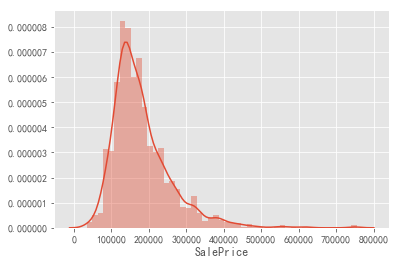

In [8]:
# 由 data_description 里面的内容的可知，对于数值型数据，如 MasVnrArea 
#表示砖石贴面面积，如果一个房子本身没有砖石贴面，则缺失值就用 0 来填补 
data['MasVnrArea'].fillna(0, inplace=True)

# 对于 GarageYrBlt 车库建造时间，空值表示未建造，可将其离散化，用 None 填充 
# 对时间特征每 20 年分一个段
year_map = pd.concat(pd.Series('YearGroup' + str(i+1),
       index=range(1871+i*20,1891+i*20)) for i in range(0, 7)) 
data['GarageYrBlt'] = data['GarageYrBlt'].map(year_map)
# 对时间缺失值用‘None’填充
data['GarageYrBlt']= data['GarageYrBlt'].fillna('None')

# 常看是否还有空值，最终结果为空即不存在 
data.isnull().sum()[data.isnull().sum() > 0]

# 分析 SalePrice
# 查看 SalePrice 均值，方差，最大最小等值，检查是否正常 
data['SalePrice'].describe()

# 可视化展示'SalePrice'分布情况 # 画出概率密度图
sns.distplot(data['SalePrice'])
plt.show()

Skewness: 1.882876
Kurtosis: 6.536282


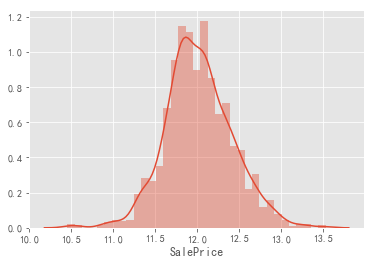

In [9]:
# 偏度 skewness and 峰度 kurtosis 计算
# 偏度值离 0 越远，则越偏
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

# 由上面结果可知，偏度大于 0.75，则向左偏，采用 ln(x+1)进行转化 
data['SalePrice'] = np.log1p(data["SalePrice"])
# 画出概率密度图
sns.distplot(data['SalePrice'])
plt.show()

Skewness: 0.121347
Kurtosis: 0.809519
(1448, 74)


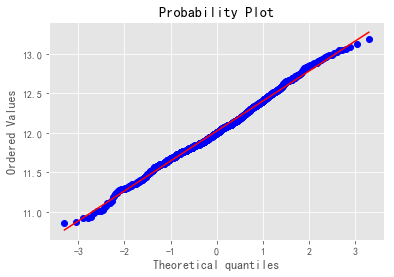

In [10]:
#转换后，偏度 skewness and 峰度 kurtosis 计算 
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

# 删除基于 SalePrice3 倍标准差的异常值 
data=data[np.abs(data['SalePrice']-data['SalePrice'].mean())<=(3*data['SalePrice'].std())]

# 画 qq 图，该图斜率表示标准差，截距为均值， 
# 查看 SalePrice 是否服从正态分布
# 越接近直线，越显正态性
res = stats.probplot(data['SalePrice'], plot=plt)

# 查看数据维度 
print(data.shape)

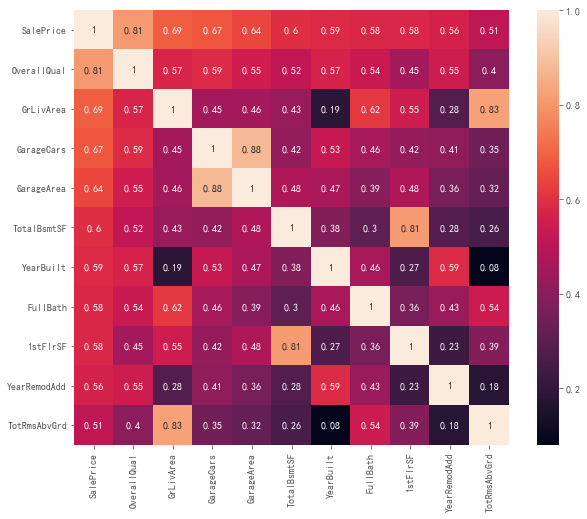

In [11]:
# 相关性分析
# 数值型数据分析
# 计算所有数值型特征与房价的相关系数
corrmat = data.corr()
# 计算与房价相关性大于 0.5 的特征个数
k = len(corrmat[corrmat['SalePrice'] > 0.5].index) 
# 获取前 k 个重要的特征名
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index.tolist()
# 计算该 k 个特征的相关系数
cm = data[cols].corr()
# 画出可视化热图
plt.figure(figsize=(10,8)) 
sns.heatmap(cm,annot=True,square=True) 
plt.show()

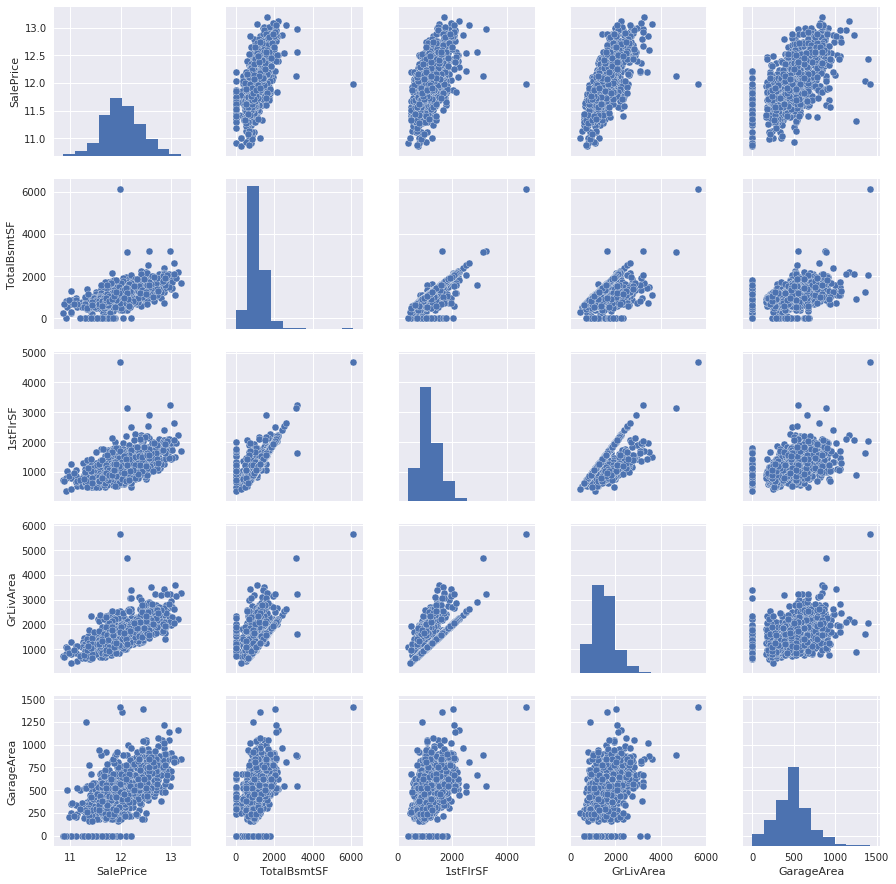

In [12]:
# 对面积特征画多变量图
sns.set()
area = ['SalePrice','TotalBsmtSF','1stFlrSF', 'GrLivArea', 'GarageArea']
sns.pairplot(data[area], size = 2.5)
plt.show()

(1443, 74)
Skewness: 0.414384
Kurtosis: 1.539572
Skewness: 0.867507
Kurtosis: 1.100841
Skewness: 0.820895
Kurtosis: 0.901041
Skewness: 0.022238
Kurtosis: 0.448625
Skewness: 0.022909
Kurtosis: -0.200772
Skewness: -0.059680
Kurtosis: -0.241430


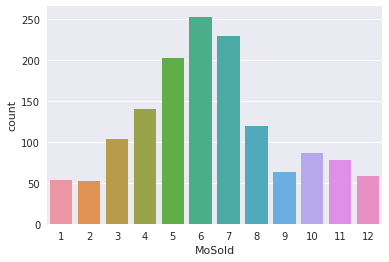

In [13]:
# 由上图第一行后三个图可知基于'TotalBsmtSF','1stFlrSF', 'GrLivArea','GarageArea' 
# 特征分别存在 1、1、2、4 个异常值，可剔除掉
data.drop(data[data['TotalBsmtSF'] > 4000].index, inplace=True) 
data.drop(data[data['1stFlrSF'] > 4000].index, inplace=True) 
data.drop(data[data['GrLivArea'] > 4000].index, inplace=True) 
data.drop(data[data['GarageArea'] > 1240].index, inplace=True)

# 查看数据维度
print(data.shape)

# 分别计算'TotalBsmtSF','1stFlrSF', 'GrLivArea'， 
#‘GarageArea'偏度 skewness and 峰度 kurtosis 计算 
print("Skewness: %f" % data['TotalBsmtSF'].skew()) 
print("Kurtosis: %f" % data['TotalBsmtSF'].kurt())

print("Skewness: %f" % data['1stFlrSF'].skew()) 
print("Kurtosis: %f" % data['1stFlrSF'].kurt())
print("Skewness: %f" % data['GrLivArea'].skew()) 
print("Kurtosis: %f" % data['GrLivArea'].kurt()) 
print("Skewness: %f" % data['GarageArea'].skew()) 
print("Kurtosis: %f" % data['GarageArea'].kurt())

# 将偏度大于 0.75 的'1stFlrSF', 'GrLivArea'进行 ln(x + 1)
#转化生成新特征‘ln_1stFlrSF’和‘ln_GrLivArea’
data['ln_1stFlrSF'] = np.log1p(data["1stFlrSF"]) 
data['ln_GrLivArea'] = np.log1p(data["GrLivArea"]) 
print("Skewness: %f" % data['ln_1stFlrSF'].skew()) 
print("Kurtosis: %f" % data['ln_1stFlrSF'].kurt()) 
print("Skewness: %f" % data['ln_GrLivArea'].skew()) 
print("Kurtosis: %f" % data['ln_GrLivArea'].kurt())

# 查看非线性特征，不同月份的房子的销售量 
# 画出直方图，查看呈现规律
sns.countplot(x='MoSold',data=data) 
plt.show()

In [18]:
# 查看数据特征类型, 即除 SalePrice 的列，有数值类型(numerical)和类别类型(category) 
numeric = [f for f in data.drop(['SalePrice'], axis=1).columns
          if data.drop(['SalePrice'], axis=1).dtypes[f] != 'object'] 
category = [f for f in data.drop(['SalePrice'], axis=1).columns
          if data.drop(['SalePrice'], axis=1).dtypes[f] == 'object']

# 输出数值类型(numerical)特征个数，类型(category)特征个数
print("numeric: {}, category: {}" .format (len(numeric),len(category)))

# 对类别型数据做方差分析
# 定义方差函数，返回 p-value 值，其值越小对应特征越重要 
def anova(frame):
    anv = pd.DataFrame() 
    anv['feature'] = category 
    pvals = []
    for c in category: 
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values 
            samples.append(s)
        # stats.f_onewaym 模块包由于计算 p-value 
        pval = stats.f_oneway(*samples)[1] 
        pvals.append(pval)
    anv['pval'] = pvals
    # 将特征根据 p-valu 排序
    return anv.sort_values('pval')

# 将 data 带入定义的方差函数
a = anova(data) 
# 输出 a
a

numeric: 36, category: 39


,feature,pval
7,Neighborhood,2.348768e-237
17,ExterQual,8.553538e-194
29,KitchenQual,2.905300e-184
20,BsmtQual,6.686655e-184
33,GarageFinish,9.518461e-150
32,GarageYrBlt,1.216344e-143
31,GarageType,4.516320e-122
19,Foundation,1.642325e-109
26,HeatingQC,5.024923e-79
23,BsmtFinType1,4.325070e-76


In [19]:
# 重要数值型特征数据整合 
# 用新的 df 构建数据集

# 选择相关性大于 0.5 的重要数值型特征 
df = data[cols]

# 将 1stFlrSF 和 GrLivArea 特征 ln(x+1)转化 
df["1stFlrSF"] = data['ln_1stFlrSF']
df["GrLivArea"] = data['ln_GrLivArea']
# 将时间特征离散化，即没 20 年分段
df['YearBuilt'] = df['YearBuilt'].map(year_map) 
df['YearRemodAdd'] = df['YearRemodAdd'].map(year_map) 
# 对非线性特征 MoSold one-hot 编码
month = pd.get_dummies(data['MoSold'],prefix='MoSold') 
# 合并特征
df = pd.concat([df, month], axis=1)

# 对于类别型数据，跟据方差分析，选取排名重要的 25 个特征 
features = a['feature'].tolist()[0:25]
# 合并特征
df = pd.concat([df, data[features]], axis=1)

# 查看特征维度 
print(df.shape)

(1443, 48)


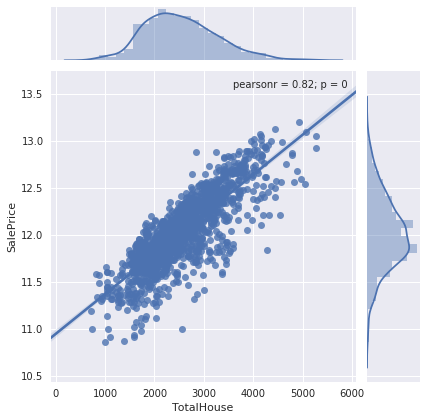

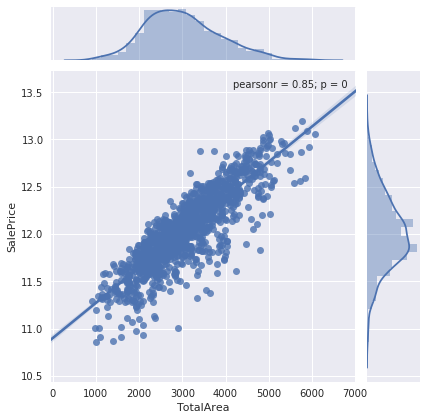

In [21]:
# 特征融合
# 将面积特征相加，构建总面积特征
df["TotalHouse"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"] 
df["TotalArea"]=data["TotalBsmtSF"]+data["1stFlrSF"]+data["2ndFlrSF"]+data["GarageArea"]
# 画出其回归图
sns.jointplot(x=df["TotalHouse"], y=df['SalePrice'], data = df, kind="reg") 
sns.jointplot(x=df["TotalArea"], y=df['SalePrice'], data = df, kind="reg") 
plt.show()

In [23]:
# 由图可知融合的特征较好，TotalHouse、TotalArea 分别含有 1 个异常,可将其剔除掉 
df.drop(df[df['TotalHouse'] > 6000].index, inplace=True) 
df.drop(df[df['TotalArea'] > 6500].index, inplace=True)

# 继续融合特征
# 将部分相关联的特征进行相加或相乘
df["+_TotalHouse_OverallQual"] = df["TotalHouse"] * data["OverallQual"] 
df["+_GrLivArea_OverallQual"] = data["GrLivArea"] * data["OverallQual"] 
df["+_BsmtFinSF1_OverallQual"] = data["BsmtFinSF1"] * data["OverallQual"] 
df["-_LotArea_OverallQual"] = data["LotArea"] * data["OverallQual"] 
df["-_TotalHouse_LotArea"] = df["TotalHouse"] + data["LotArea"]
df["Bsmt"] = data["BsmtFinSF1"] + data["BsmtFinSF2"] + data["BsmtUnfSF"] 
df["Rooms"] = data["FullBath"]+data["TotRmsAbvGrd"]
df["PorchArea"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
# \ 表示换行
df["TotalPlace"] = df["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"] + data["GarageArea"] + \
                 data["OpenPorchSF"] + data["EnclosedPorch"]+ data["3SsnPorch"] + data["ScreenPorch"]
# 将所有的类别型特征，one-hot 编码

df = pd.get_dummies(df) 
# 查看数据维度
print(df.shape)

(1442, 216)


In [24]:
# 构建模型
# 导入 GBDT 算法
from sklearn.ensemble import GradientBoostingRegressor
# 导入均方误差计算
from sklearn.metrics import mean_squared_error
# 导入标准化模块包
from sklearn.preprocessing import RobustScaler
# 导入划分数据集包，交叉验证包
from sklearn.model_selection import train_test_split,KFold,cross_val_score 
# 导入 Xgboost 算法包
import xgboost as xgb

In [27]:
# 特征标准化
x = RobustScaler().fit_transform(df.drop(['SalePrice'], axis=1).values)
# 提取标签
y = df['SalePrice'].values

# 定义验证函数,使用 5 折交叉验证，采用均方根误差判别，返回均方根误差 
def rmse_cv(model):
     # 将数据集使用 shuffle 打乱，划分成五分
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # 计算均方根误差，其输出结果有五个
    rmse= np.sqrt(-cross_val_score(model,x,y,scoring="neg_mean_squared_error",cv = kf))
    return rmse

In [29]:
# 使用 GBDT 算法，构建模型
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.005,
                     max_depth=4, max_features='sqrt', 
                     min_samples_leaf=15, min_samples_split=10,
                     loss='huber', random_state =5)
score1 = rmse_cv(GBoost)

# 输出五个均方根误差的平均值 RSME 和其标准差 SD,保留 4 位小数
print("Gradient Boosting score: RSME={:.4f} (SD={:.4f})\n".format(score1.mean (),score1.std()))

Gradient Boosting score: RSME=0.1130 (SD=0.0113)



In [31]:
# Xgboost 算法,构建模型
Xgboost = xgb.XGBRegressor(colsample_bytree=0.36, gamma=0.042,
                           learning_rate=0.05,max_depth=3, 
                           min_child_weight=1.88, n_estimators=2200, 
                           reg_alpha=0.4640, reg_lambda=0.8571, 
                           subsample=0.5213, silent=1,
                           random_state = 1, nthread = -1)

score2 = rmse_cv(Xgboost)
# 输出五个均方根误差的平均值 RSME 和其标准差 SD,保留 4 位小数
print("Xgboost score: RSME={:.4f} (SD={:.4f})\n".format(score2.mean(),score2.std()))

Xgboost score: RSME=0.1180 (SD=0.0096)



In [32]:
# 将 80%数据作为训练集，20%数据作为测试集

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
# 定义回归拟合图,以预测值输入 
def drawing(y_hat):
    # 获取预测的测试集从小到大排序的索引 
    order = np.argsort(y_hat)
    # 将测试集和预测的测试集按索引排序 
    y_test_new = y_test[order] 
    y_hat = y_hat[order]
    # 画图展示
    plt.figure(figsize=(8, 6),facecolor='w')
    t = np.arange(len(y_test))
    plt.plot(t, y_test_new, 'b-', linewidth=2, label='True') 
    plt.plot(t, y_hat, 'r-', linewidth=2, label='Predicted') 
    plt.legend(loc='upper left')
    plt.grid(b=True) 
    plt.show()


RMSE = 0.0984
R2_train = 0.9492
R2_test = 0.9274


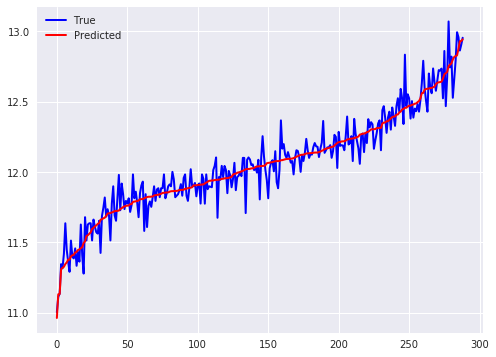

In [33]:
# 训练集训练模型
GBoost.fit(x_train, y_train)
# 测试集结果预测
y_hat1 = GBoost.predict(x_test)
# 分别输出均方根误差 RMSE，训练集和测试集的拟合优度 R2
print("RMSE = %.4f" % np.sqrt(np.mean((y_hat1 - y_test) ** 2))) 
print('R2_train = %.4f' % GBoost.score(x_train, y_train)) 
print('R2_test = %.4f' % GBoost.score(x_test, y_test))
# 画出拟合效果图，蓝色表示真实值，红色为预测值
drawing(y_hat1)

RMSE = 0.1044
R2_train = 0.9492
R2_test = 0.9274


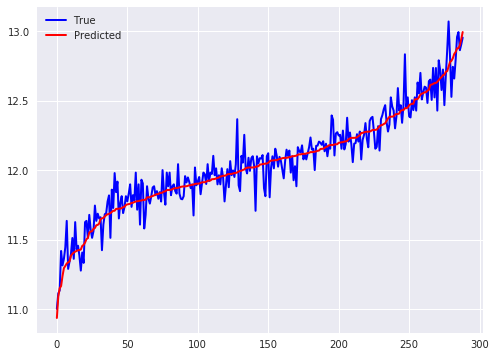

In [34]:
# 使用 Xgboost 算法，构建模型
# 训练集训练
Xgboost.fit(x_train, y_train) 
# 测试集结果预测
y_hat2 = Xgboost.predict(x_test)

# 分别输出均方根误差 RMSE，训练集和测试集的拟合优度 R2
print("RMSE = %.4f" % np.sqrt(np.mean((y_hat2 - y_test) ** 2))) 
print('R2_train = %.4f' % GBoost.score(x_train, y_train)) 
print('R2_test = %.4f' % GBoost.score(x_test, y_test))
# 画出拟合效果图 ，蓝色表示真实值，红色为预测值
drawing(y_hat2)
